In [2]:
import cv2
import numpy as np
import torch
from torch.nn import functional as F
from IPython.display import display
from PIL import Image
from einops import rearrange, repeat

In [24]:
# 假设输入是一个 1x1x3x3 的张量  
input = torch.tensor([[[[1, 2, 3],  
                        [4, 5, 6],  
                        [7, 8, 9]]]], dtype=torch.float)  

# 定义一个仿射变换矩阵 (这里是单位矩阵，不做任何变换)  
theta = torch.tensor([[[1, 0, 0],  
                       [0, 1, 0]]], dtype=torch.float)  

# 生成 grid  
grid = F.affine_grid(theta, input.size())
print(grid, grid.shape)

# 使用 grid_sample 进行采样  
output = F.grid_sample(input, grid)  
print(output)

# y, x = torch.meshgrid(torch.linspace(-1, 1, 3), torch.linspace(-1, 1, 3))
# grid = torch.stack((x, y), dim=-1)
# print(grid, grid.shape)

H, W = 3, 3
# 创建坐标网格  
y, x = torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij')  

# 计算像素中心并归一化到 [-1, 1]  
x = (2.0 * x + 1) / W - 1.0  
y = (2.0 * y + 1) / H - 1.0  

# 将 x 和 y 坐标组合成 grid  
grid = torch.stack((x, y), dim=-1)  # 形状为 (H, W, 2)  
print(grid)
# output = F.grid_sample(input, grid[None, ...], mode='nearest')  
output = F.grid_sample(input, grid[None, ...])  
print(output)

tensor([[[[-0.6667, -0.6667],
          [ 0.0000, -0.6667],
          [ 0.6667, -0.6667]],

         [[-0.6667,  0.0000],
          [ 0.0000,  0.0000],
          [ 0.6667,  0.0000]],

         [[-0.6667,  0.6667],
          [ 0.0000,  0.6667],
          [ 0.6667,  0.6667]]]]) torch.Size([1, 3, 3, 2])
tensor([[[[1., 2., 3.],
          [4., 5., 6.],
          [7., 8., 9.]]]])
tensor([[[-0.6667, -0.6667],
         [ 0.0000, -0.6667],
         [ 0.6667, -0.6667]],

        [[-0.6667,  0.0000],
         [ 0.0000,  0.0000],
         [ 0.6667,  0.0000]],

        [[-0.6667,  0.6667],
         [ 0.0000,  0.6667],
         [ 0.6667,  0.6667]]])
tensor([[[[1.0000, 2.0000, 3.0000],
          [4.0000, 5.0000, 6.0000],
          [7.0000, 8.0000, 9.0000]]]])


/mnt/data2/zhanghm/miniconda3/envs/bevdet_py38/lib/python3.8/site-packages/torch/nn/functional.py:4255: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/mnt/data2/zhanghm/miniconda3/envs/bevdet_py38/lib/python3.8/site-packages/torch/nn/functional.py:4193: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


torch.Size([6, 442, 512, 2])
torch.Size([6, 3, 442, 512])


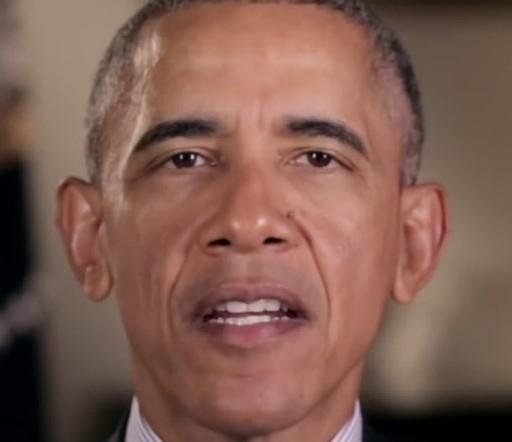

In [7]:

def make_grid(H, W):
    y, x = torch.meshgrid(torch.linspace(-1, 1, H), torch.linspace(-1, 1, W))
    grid = torch.stack((x, y), dim=-1)
    return grid

img = cv2.imread('./data/obama_2.jpg')  # (H, W, 3) in [0, 255]
img = torch.from_numpy(img) / 255.0 # (H, W, 3) in [0, 1]
img = repeat(img.float(), 'H W C -> 6 C H W')  # (bs, C, H, W)

H, W = img.shape[-2:]
grid_ori = make_grid(H, W)
grid_ori = repeat(grid_ori, 'H W C -> 6 H W C')  # (bs, H, W, 2)
print(grid_ori.shape)

# normalize the grid
grid = grid_ori.float().clone()
# grid[..., 0] /= W
# grid[..., 1] /= H
# grid = 2 * grid - 1
pixel_rgb = F.grid_sample(
    img, 
    grid, 
    mode='bilinear',
    padding_mode='zeros',
    align_corners=True) # B, C, H, W
print(pixel_rgb.shape)

pixel_rgb = rearrange(pixel_rgb, 'B C H W -> B H W C')

img_show = pixel_rgb[0].numpy() * 255.0
img_show = img_show.astype(np.uint8)
display(Image.fromarray(img_show[..., ::-1]))

(512, 512, 3)
torch.Size([1, 6, 3, 512, 512]) img
torch.Size([1, 6, 262144, 2])
torch.Size([1, 6, 262144, 3])
torch.Size([1, 6, 512, 512, 3])
tensor(-0.2117) tensor(0.1849) tensor(0.0004)


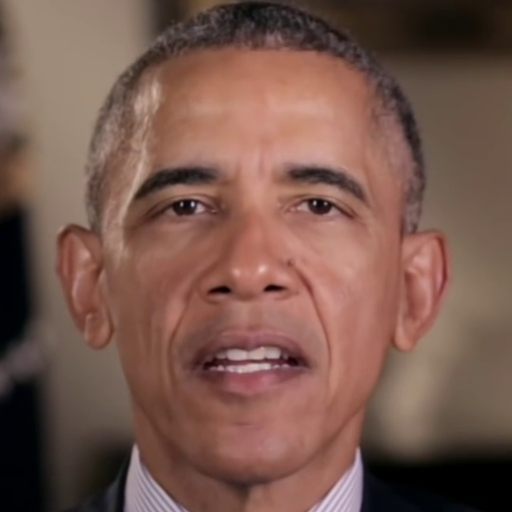

In [6]:
def make_coords(bs, num_cam, H, W):
    ray_x = torch.arange(W, dtype=torch.float)
    ray_y = torch.arange(H, dtype=torch.float)
    ray_coords = torch.stack([
        ray_x.unsqueeze(0).expand(H, -1),
        ray_y.unsqueeze(1).expand(-1, W)], dim=-1) # H, W, 2
    ray_coords = ray_coords.flatten(0, 1) # HW, 2
    ray_coords = repeat(ray_coords, 'HW dim2 -> bs num_cam HW dim2', bs=bs, num_cam=num_cam)
    return ray_coords

def sample_pixel(pixel, imgs):
    # imgs: B, N, 3, H, W
    # pixel: B, N, 1, R, 2
    bs, num_cam, _, H, W = imgs.shape
    pixel = pixel.clone()
    pixel[..., 0] /= W
    pixel[..., 1] /= H
    pixel = 2 * pixel - 1
    pixel_rgb = F.grid_sample(
        imgs.flatten(0, 1), 
        pixel.flatten(0, 1), 
        mode='bilinear',
        padding_mode='border',
        align_corners=True) # BN, 3, 1, R
    pixel_rgb = rearrange(
        pixel_rgb, '(bs num_cam) dim3 dim1 R -> bs num_cam R (dim3 dim1) ', 
        bs=bs, num_cam=num_cam)
    return pixel_rgb

img = cv2.imread('./data/obama_2.jpg')
print(img.shape)
img = torch.from_numpy(img) / 255.0
img = repeat(img.float(), 'H W C -> 1 6 C H W')
print(img.shape, "img")

coords = make_coords(1, 6, img.shape[-2], img.shape[-1])
print(coords.shape)
coords = coords.unsqueeze(2)
img_output = sample_pixel(coords, img)
print(img_output.shape)
img_output = rearrange(img_output, 'bs num_cam (H W) dim3 -> bs num_cam H W dim3', H=512, W=512)
print(img_output.shape)

dd = img_output - rearrange(img, 'bs num_cam C H W -> bs num_cam H W C')
print(dd.min(), dd.max(), dd.mean())

img_show = img_output[0, 0].numpy() * 255.0
img_show = img_show.astype(np.uint8)
display(Image.fromarray(img_show[..., ::-1]))

https://blog.csdn.net/qq_34914551/article/details/110186855

(1, 3, 256, 256)
torch.Size([1, 256, 256, 2]) torch.float32 tensor(-1.3607) tensor(1.3607)
torch.Size([1, 3, 256, 256]) tensor(0.) tensor(240.)


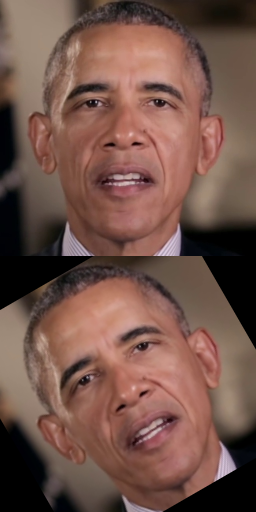

In [18]:
img = cv2.imread('../torchvision_learn/data/obama.jpg')
img = cv2.resize(img, dsize=None, dst=None, fx=0.5, fy=0.5)
size = img.shape[:2]
size = (1, 3,) + size
print(size)

angle = 30 * np.pi / 180  # np默认角度为弧度制

theta = np.array([np.cos(angle), np.sin(-angle), 0,
                    np.sin(angle), np.cos(angle), 0])  # 30度的旋转矩阵
theta = theta.reshape(1, 2, 3)

theta = torch.from_numpy(theta).float()  # 调整dtype
grid = F.affine_grid(theta, size=torch.Size(size))  # 得到grid 用于grid sample
print(grid.shape, grid.dtype, grid.min(), grid.max())

# print(grid.min(), grid.max())
# grid = torch.clamp(grid, -1, 1)
img_tensor = torch.from_numpy(img).float().permute(2, 0, 1).unsqueeze(0)
print(img_tensor.shape, img_tensor.min(), img_tensor.max())

warp_img = F.grid_sample(img_tensor, grid).squeeze().permute(1, 2, 0).numpy()
warp_img = np.clip(warp_img, 0, 255).astype(np.uint8)


img_vis = np.concatenate((img, warp_img), axis=0) # 原图在上，affined在下
display(Image.fromarray(img_vis[..., ::-1]))
# cv2.imshow('res', img_vis)
# cv2.waitKey()
